# Titanic — Data Cleaning & Preprocessing

Steps included:

1. Load dataset (expects `data/titanic.csv`).
2. Exploratory Data Analysis (missing values, dtypes, distributions).
3. Handle missing values (median/mean/mode, smart imputation).
4. Feature engineering (title extraction, family size, deck extraction).
5. Encoding categorical variables (One-Hot / Ordinal where appropriate).
6. Scaling numeric features (StandardScaler) and pipeline creation.
7. Outlier detection & removal using IQR and visualization via boxplots.
8. Export cleaned dataset and pipeline for modeling.



In [17]:
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_PATH = Path('data/Titanic-Dataset.csv')

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
    print('Loaded data/titanic.csv')
else:
    import seaborn as sns
    df = sns.load_dataset('titanic')
    # seaborn's titanic has slightly different columns; provide a note
    print('data/titanic.csv not found — using seaborn built-in Titanic dataset for demo')

print('\nShape:', df.shape)
df.head()

Loaded data/titanic.csv

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1) Quick overview & missing values
Let's inspect data types, missing percentages and an initial plan.

In [18]:
def missing_table(dataframe):
    miss = dataframe.isnull().sum()
    pct = (miss / len(dataframe) * 100).round(2)
    out = pd.concat([miss, pct], axis=1)
    out.columns = ['missing_count', 'missing_pct']
    return out.sort_values('missing_count', ascending=False)

print(missing_table(df))

print('\nInfo:')
print(df.info())

             missing_count  missing_pct
Cabin                  687        77.10
Age                    177        19.87
Embarked                 2         0.22
PassengerId              0         0.00
Survived                 0         0.00
Pclass                   0         0.00
Name                     0         0.00
Sex                      0         0.00
SibSp                    0         0.00
Parch                    0         0.00
Ticket                   0         0.00
Fare                     0         0.00

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null  

## 2) Feature engineering ideas
- Extract Title from `Name` (if present).
- Family size from `SibSp` + `Parch`.
- Extract Deck from `Cabin` (first letter) when available.
- Convert `Sex`, `Embarked` using One-Hot / Ordinal encodings.
- Impute `Age` with median of Title-group (smarter imputation).
- Fill `Fare` missing with median.


In [19]:
# Make copies
data = df.copy()

# Normalize column names to lower-case strings for robustness
data.columns = [c.lower() for c in data.columns]

# Example transformations only when expected columns exist
if 'name' in data.columns:
    # extract title
    data['title'] = data['name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
    # group rare titles
    title_map = (data['title'].value_counts()[data['title'].value_counts() < 10].index.tolist())
    data['title'] = data['title'].replace(title_map, 'Rare')

# family size
if set(['sibsp','parch']).issubset(data.columns):
    data['family_size'] = data['sibsp'] + data['parch'] + 1

# deck extraction
if 'cabin' in data.columns:
    data['deck'] = data['cabin'].astype(str).str[0].replace('n', np.nan)

# Quick look
data[[c for c in ['title','family_size','deck'] if c in data.columns]].head()

,title,family_size,deck
0,Mr,2,NaN
1,Mrs,2,C
2,Miss,1,NaN
3,Mrs,2,C
4,Mr,1,NaN


## 3) Handling missing values — smart strategy
- Age: impute median per Title group (if Title exists), else median overall.
- Embarked: fill with mode.
- Fare: median.
- Cabin/Deck: 'Missing' label.


In [20]:
# Age imputation by title if possible
if 'age' in data.columns:
    if 'title' in data.columns:
        data['age'] = data['age'].fillna(
            data.groupby('title')['age'].transform('median')
        )
    else:
        data['age'] = data['age'].fillna(data['age'].median())

# Embarked
if 'embarked' in data.columns:
    data['embarked'] = data['embarked'].fillna(data['embarked'].mode().iloc[0])

# Fare
if 'fare' in data.columns:
    data['fare'] = data['fare'].fillna(data['fare'].median())

# Deck/Cabin
if 'deck' in data.columns:
    data['deck'] = data['deck'].fillna('Missing')
if 'cabin' in data.columns:
    data['cabin'] = data['cabin'].fillna('Missing')

print("After imputation:")
print(missing_table(data))


After imputation:
             missing_count  missing_pct
passengerid              0          0.0
survived                 0          0.0
pclass                   0          0.0
name                     0          0.0
sex                      0          0.0
age                      0          0.0
sibsp                    0          0.0
parch                    0          0.0
ticket                   0          0.0
fare                     0          0.0
cabin                    0          0.0
embarked                 0          0.0
title                    0          0.0
family_size              0          0.0
deck                     0          0.0


## 4) Encoding categorical features
- For low-cardinality nominal features: One-Hot Encoding.
- For ordinal or title-like: Label/Ordinal encoding.
We'll build a sklearn `ColumnTransformer` and `Pipeline` to ensure reproducibility.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Identify types
num_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = data.select_dtypes(include=['object','category']).columns.tolist()
# drop target if present (e.g., 'survived') from features
if 'survived' in num_cols:
    num_cols.remove('survived')
if 'survived' in cat_cols:
    cat_cols.remove('survived')

# choose sensible defaults
num_cols, cat_cols


(['passengerid', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'family_size'],
 ['name', 'sex', 'ticket', 'cabin', 'embarked', 'title', 'deck'])

In [23]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ✅ Fixed categorical transformer
try:
    # For scikit-learn >= 1.2
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    # Fallback for scikit-learn < 1.2
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# Full pipeline
full_pipeline = make_pipeline(preprocessor)

# Fit transformer on data (drop target if present)
X = data.drop(columns=['survived']) if 'survived' in data.columns else data.copy()
full_pipeline.fit(X)

print('✅ Preprocessing pipeline fitted successfully.')


✅ Preprocessing pipeline fitted successfully.


## 5) Outlier detection & removal (IQR method)
We'll demonstrate using Fare and Age (if present). Remove extreme outliers per numeric column using 1.5*IQR rule.

In [25]:
def remove_outliers_iqr(df_, cols):
    df = df_.copy()
    for col in cols:
        if col not in df.columns: 
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= low) & (df[col] <= high)]
        after = df.shape[0]
        print(f'Removed {before-after} rows based on outliers in {col}')
    return df

numeric_for_outliers = [c for c in ['age','fare'] if c in data.columns]
cleaned = remove_outliers_iqr(data, numeric_for_outliers)

print('\nShape before:', data.shape)
print('Shape after:', cleaned.shape)

Removed 35 rows based on outliers in age
Removed 109 rows based on outliers in fare

Shape before: (891, 15)
Shape after: (747, 15)


### Visualize with boxplots

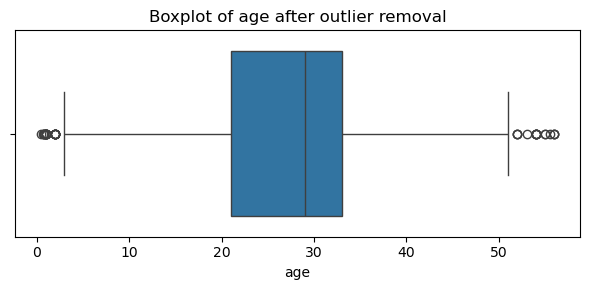

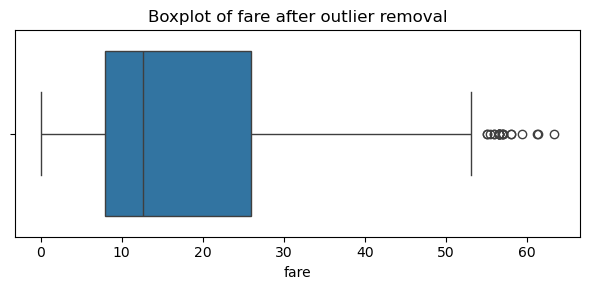

In [26]:
for col in numeric_for_outliers:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=cleaned[col])
    plt.title(f'Boxplot of {col} after outlier removal')
    plt.tight_layout()
    plt.show()

## 6) Export cleaned data & pipeline
Save cleaned CSV and the sklearn pipeline (using joblib) for future modeling.

In [27]:
import joblib

OUT_DIR = Path('output')
OUT_DIR.mkdir(exist_ok=True)

cleaned.to_csv(OUT_DIR / 'titanic_cleaned.csv', index=False)
joblib.dump(full_pipeline, OUT_DIR / 'preprocessing_pipeline.joblib')
print('Saved cleaned dataset and preprocessing pipeline to', OUT_DIR.resolve())

Saved cleaned dataset and preprocessing pipeline to C:\Users\SHIVANI\Downloads\GitHub\Data-Cleaning-Pre-Processing\titanic_preprocessing\output
